<a href="https://colab.research.google.com/github/FedyaBadyilo/Skin-Cancer-Detection/blob/main/metadata_classification.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [24]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
pip install catboost; pip install optuna; pip install phik

In [74]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import phik as p

from sklearn.model_selection import StratifiedGroupKFold, cross_val_score, train_test_split, cross_validate, GridSearchCV
from sklearn.preprocessing import OneHotEncoder, LabelEncoder, StandardScaler
from sklearn.metrics import roc_auc_score, recall_score, make_scorer
from sklearn.ensemble import VotingClassifier, RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.utils.class_weight import compute_class_weight
from sklearn.feature_selection import mutual_info_classif
from sklearn.pipeline import make_pipeline

from imblearn.under_sampling import RandomUnderSampler
from imblearn.over_sampling import RandomOverSampler
from imblearn.pipeline import Pipeline

import lightgbm as lgb
import catboost as cb
import xgboost as xgb
import optuna


import tqdm

# импорт и обзор данных

In [4]:
!unzip '/content/drive/MyDrive/Colab Notebooks/ISIC_hack/isic-2024-challenge.zip'

Выходные данные были обрезаны до нескольких последних строк (5000).
  inflating: train-image/image/ISIC_9874656.jpg  
  inflating: train-image/image/ISIC_9874659.jpg  
  inflating: train-image/image/ISIC_9874663.jpg  
  inflating: train-image/image/ISIC_9874742.jpg  
  inflating: train-image/image/ISIC_9874751.jpg  
  inflating: train-image/image/ISIC_9874803.jpg  
  inflating: train-image/image/ISIC_9874805.jpg  
  inflating: train-image/image/ISIC_9874832.jpg  
  inflating: train-image/image/ISIC_9874878.jpg  
  inflating: train-image/image/ISIC_9874897.jpg  
  inflating: train-image/image/ISIC_9874925.jpg  
  inflating: train-image/image/ISIC_9874931.jpg  
  inflating: train-image/image/ISIC_9874939.jpg  
  inflating: train-image/image/ISIC_9874940.jpg  
  inflating: train-image/image/ISIC_9874963.jpg  
  inflating: train-image/image/ISIC_9874987.jpg  
  inflating: train-image/image/ISIC_9875007.jpg  
  inflating: train-image/image/ISIC_9875010.jpg  
  inflating: train-image/image/I

In [5]:
df = pd.read_csv('/content/train-metadata.csv', low_memory=False)
df_test = pd.read_csv('/content/test-metadata.csv')

In [6]:
df.head()

,isic_id,target,patient_id,age_approx,sex,anatom_site_general,clin_size_long_diam_mm,image_type,tbp_tile_type,tbp_lv_A,...,lesion_id,iddx_full,iddx_1,iddx_2,iddx_3,iddx_4,iddx_5,mel_mitotic_index,mel_thick_mm,tbp_lv_dnn_lesion_confidence
0,ISIC_0015670,0,IP_1235828,60.0,male,lower extremity,3.04,TBP tile: close-up,3D: white,20.244422,...,NaN,Benign,Benign,NaN,NaN,NaN,NaN,NaN,NaN,97.517282
1,ISIC_0015845,0,IP_8170065,60.0,male,head/neck,1.10,TBP tile: close-up,3D: white,31.712570,...,IL_6727506,Benign,Benign,NaN,NaN,NaN,NaN,NaN,NaN,3.141455
2,ISIC_0015864,0,IP_6724798,60.0,male,posterior torso,3.40,TBP tile: close-up,3D: XP,22.575830,...,NaN,Benign,Benign,NaN,NaN,NaN,NaN,NaN,NaN,99.804040
3,ISIC_0015902,0,IP_4111386,65.0,male,anterior torso,3.22,TBP tile: close-up,3D: XP,14.242329,...,NaN,Benign,Benign,NaN,NaN,NaN,NaN,NaN,NaN,99.989998
4,ISIC_0024200,0,IP_8313778,55.0,male,anterior torso,2.73,TBP tile: close-up,3D: white,24.725520,...,NaN,Benign,Benign,NaN,NaN,NaN,NaN,NaN,NaN,70.442510


In [7]:
df_test.head()

,isic_id,patient_id,age_approx,sex,anatom_site_general,clin_size_long_diam_mm,image_type,tbp_tile_type,tbp_lv_A,tbp_lv_Aext,...,tbp_lv_radial_color_std_max,tbp_lv_stdL,tbp_lv_stdLExt,tbp_lv_symm_2axis,tbp_lv_symm_2axis_angle,tbp_lv_x,tbp_lv_y,tbp_lv_z,attribution,copyright_license
0,ISIC_0015657,IP_6074337,45.0,male,posterior torso,2.70,TBP tile: close-up,3D: XP,22.80433,20.007270,...,0.304827,1.281532,2.299935,0.479339,20,-155.06510,1511.222000,113.980100,Memorial Sloan Kettering Cancer Center,CC-BY
1,ISIC_0015729,IP_1664139,35.0,female,lower extremity,2.52,TBP tile: close-up,3D: XP,16.64867,9.657964,...,0.000000,1.271940,2.011223,0.426230,25,-112.36924,629.535889,-15.019287,"Frazer Institute, The University of Queensland...",CC-BY
2,ISIC_0015740,IP_7142616,65.0,male,posterior torso,3.16,TBP tile: close-up,3D: XP,24.25384,19.937380,...,0.230742,1.080308,2.705857,0.366071,110,-84.29282,1303.978000,-28.576050,FNQH Cairns,CC-BY


In [8]:
df.target.value_counts().values

array([400666,    393])

In [9]:
percentage = [c/df.target.count() for c in df.target.value_counts().values]
pd.concat([pd.Series(data = ['benign', 'malignant'], name = 'lesion '), df.target.value_counts(), pd.Series(data = percentage, name = 'percentage')], axis = 1)

,lesion,count,percentage
0,benign,400666,0.99902
1,malignant,393,0.00098


как видно, данные имеют огромный дисбаланс, что довольно закономерно, когда речь идет о раковых поражениях.

In [10]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 401059 entries, 0 to 401058
Data columns (total 55 columns):
 #   Column                        Non-Null Count   Dtype  
---  ------                        --------------   -----  
 0   isic_id                       401059 non-null  object 
 1   target                        401059 non-null  int64  
 2   patient_id                    401059 non-null  object 
 3   age_approx                    398261 non-null  float64
 4   sex                           389542 non-null  object 
 5   anatom_site_general           395303 non-null  object 
 6   clin_size_long_diam_mm        401059 non-null  float64
 7   image_type                    401059 non-null  object 
 8   tbp_tile_type                 401059 non-null  object 
 9   tbp_lv_A                      401059 non-null  float64
 10  tbp_lv_Aext                   401059 non-null  float64
 11  tbp_lv_B                      401059 non-null  float64
 12  tbp_lv_Bext                   401059 non-nul

в тринировочных данных есть несколько признаков, которых нет в тестовых. это вызвано тем, что данные были собраны с огромного количества людей, и не всегда служат исключительно для обучения модели. об этом говорит большое количество пропусков в этих данных. поэтому в дальнейшем эти признаки использоваться не будут (за исключением target).

In [11]:
df.drop([col for col in df.columns if col not in df_test.columns and col != 'target'], axis = 1, inplace = True)

In [12]:
df.columns

Index(['isic_id', 'target', 'patient_id', 'age_approx', 'sex',
       'anatom_site_general', 'clin_size_long_diam_mm', 'image_type',
       'tbp_tile_type', 'tbp_lv_A', 'tbp_lv_Aext', 'tbp_lv_B', 'tbp_lv_Bext',
       'tbp_lv_C', 'tbp_lv_Cext', 'tbp_lv_H', 'tbp_lv_Hext', 'tbp_lv_L',
       'tbp_lv_Lext', 'tbp_lv_areaMM2', 'tbp_lv_area_perim_ratio',
       'tbp_lv_color_std_mean', 'tbp_lv_deltaA', 'tbp_lv_deltaB',
       'tbp_lv_deltaL', 'tbp_lv_deltaLB', 'tbp_lv_deltaLBnorm',
       'tbp_lv_eccentricity', 'tbp_lv_location', 'tbp_lv_location_simple',
       'tbp_lv_minorAxisMM', 'tbp_lv_nevi_confidence', 'tbp_lv_norm_border',
       'tbp_lv_norm_color', 'tbp_lv_perimeterMM',
       'tbp_lv_radial_color_std_max', 'tbp_lv_stdL', 'tbp_lv_stdLExt',
       'tbp_lv_symm_2axis', 'tbp_lv_symm_2axis_angle', 'tbp_lv_x', 'tbp_lv_y',
       'tbp_lv_z', 'attribution', 'copyright_license'],
      dtype='object')

# исследовательский анализ данных

прежде всего нужно разделить признаки на категориальные и постоянные

In [27]:
num_cols = [
    'age_approx',                        # Приблизительный возраст пациента на момент снимка.
    'clin_size_long_diam_mm',            # Максимальный диаметр очага в миллиметрах.
    'tbp_lv_A',                          # A внутри очага.
    'tbp_lv_Aext',                       # A снаружи очага.
    'tbp_lv_B',                          # B внутри очага.
    'tbp_lv_Bext',                       # B снаружи очага.
    'tbp_lv_C',
    # Хрома внутри очага.
    'tbp_lv_Cext',                       # Хрома снаружи очага.
    'tbp_lv_H',                          # Оттенок внутри очага; рассчитывается как угол A* и B* в цветовом пространстве LAB*. Типичные значения варьируются от 25 (красный) до 75 (коричневый).
    'tbp_lv_Hext',                       # Оттенок снаружи очага.
    'tbp_lv_L',                          # L внутри очага.
    'tbp_lv_Lext',                       # L снаружи очага.
    'tbp_lv_areaMM2',                    # Площадь очага (мм²).
    'tbp_lv_area_perim_ratio',           # Неровность границы, соотношение между периметром и площадью очага. Круглые очаги будут иметь низкие значения; неравномерно сформированные очаги будут иметь более высокие значения. Значения варьируются от 0 до 10.
    'tbp_lv_color_std_mean',             # Неровность цвета, рассчитывается как дисперсия цветов в пределах границы очага.
    'tbp_lv_deltaA',                     # Средний контраст A (внутри и снаружи очага).
    'tbp_lv_deltaB',                     # Средний контраст B (внутри и снаружи очага).
    'tbp_lv_deltaL',                     # Средний контраст L (внутри и снаружи очага).
    'tbp_lv_deltaLB',                    # Контраст между очагом поражения и кожей, непосредственно окружающей его. Малоконтрастные очаги поражения, как правило, слабо заметны, например, веснушки; высококонтрастные очаги поражения, как правило, имеют более темный пигмент. Рассчитывается как среднее значение дельта-LB очага поражения относительно его непосредственного фона в цветовом пространстве LAB*. Типичные значения варьируются от 5,5 до 25.+
    'tbp_lv_deltaLBnorm',                # Контраст между очагом и его ближайшей окружающей кожей. Очаги с низким контрастом, как правило, слабо видны, например, веснушки; очаги с высоким контрастом, как правило, имеют более темный пигмент. Рассчитывается как среднее значение delta LB очага относительно его непосредственного фона в цветовом пространстве LAB*. Типичные значения варьируются от 5.5 до 25.
    'tbp_lv_eccentricity',               # Эксцентриситет.
    'tbp_lv_minorAxisMM',                # Минимальный диаметр очага (мм).
    'tbp_lv_nevi_confidence',            # Оценка уверенности в невусе (по шкале от 0 до 100) — это вероятность, оцененная классификатором на основе свёрточной нейронной сети, что очаг является невусом. Нейронная сеть была обучена на примерно 57,000 очагов, которые были классифицированы и помечены дерматологом.
    'tbp_lv_norm_border',                # Неровность границы (по шкале от 0 до 10); нормализованное среднее значение неровности границы и асимметрии.
    'tbp_lv_norm_color',                 # Вариация цвета (по шкале от 0 до 10); нормализованное среднее значение цветовой асимметрии и неровности цвета.
    'tbp_lv_perimeterMM',                # Периметр очага (мм).
    'tbp_lv_radial_color_std_max',       # Цветовая асимметрия, мера асимметрии пространственного распределения цвета внутри очага. Этот показатель рассчитывается на основе средней стандартной девиации в цветовом пространстве LAB* в пределах концентрических колец, исходящих из центра очага. Значения варьируются от 0 до 10.
    'tbp_lv_stdL',                       # Стандартное отклонение L внутри очага.
    'tbp_lv_stdLExt',                    # Стандартное отклонение L снаружи очага.
    'tbp_lv_symm_2axis',                 # Асимметрия границы; мера асимметрии контура очага относительно оси, перпендикулярной к наиболее симметричной оси очага. Очаги с двумя осями симметрии будут иметь низкие значения (более симметричные), в то время как очаги с одной или нулевой осями симметрии будут иметь более высокие значения (менее симметричные). Этот показатель рассчитывается путем сравнения противоположных половин контура очага при различных углах поворота. Угол, при котором половины наиболее похожи, определяет главную ось симметрии, а вторая ось симметрии перпендикулярна главной оси. Асимметрия границы измеряется как значение асимметрии относительно этой второй оси. Значения варьируются от 0 до 10.
    'tbp_lv_symm_2axis_angle',           # Угол асимметрии границы очага.
    'tbp_lv_x',                          # X-координата очага в 3D TBP.
    'tbp_lv_y',                          # Y-координата очага в 3D TBP.
    'tbp_lv_z',                          # Z-координата очага в 3D TBP.
]

cat_cols = ['sex', # пол
            'anatom_site_general', # анатомическое место очага
            'tbp_tile_type', # Режим освещения исходного изображения 3D TBP
            'tbp_lv_location', # Классификация анатомического расположения делит руки и ноги на верхнюю и нижнюю части туловища на три части
            'tbp_lv_location_simple', # Классификация анатомического расположения, простая
            'attribution' # атрибуция изображения, синоним источника изображения
]

feature_cols = num_cols + cat_cols

## заполнение пропусков

первым делом избавимся от дубликатов

In [14]:
df.drop_duplicates(inplace = True)

In [15]:
df[feature_cols].info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 401059 entries, 0 to 401058
Data columns (total 40 columns):
 #   Column                       Non-Null Count   Dtype  
---  ------                       --------------   -----  
 0   age_approx                   398261 non-null  float64
 1   clin_size_long_diam_mm       401059 non-null  float64
 2   tbp_lv_A                     401059 non-null  float64
 3   tbp_lv_Aext                  401059 non-null  float64
 4   tbp_lv_B                     401059 non-null  float64
 5   tbp_lv_Bext                  401059 non-null  float64
 6   tbp_lv_C                     401059 non-null  float64
 7   tbp_lv_Cext                  401059 non-null  float64
 8   tbp_lv_H                     401059 non-null  float64
 9   tbp_lv_Hext                  401059 non-null  float64
 10  tbp_lv_L                     401059 non-null  float64
 11  tbp_lv_Lext                  401059 non-null  float64
 12  tbp_lv_areaMM2               401059 non-null  float64
 13 

пропуски в признаках age_approax, sex, anatom_site_general

In [16]:
df['age_approx'].mode()[0]

55.0

заполним пропуски в возрасте модой, так как именно в возрасте 55 лет люди чаще всего делали снимок.

In [17]:
df['age_approx'].fillna(df['age_approx'].mode()[0], inplace=True)

In [18]:
df.sex.map({'male': 1, 'female': 0}).corr(df.target)

0.002270727453374706

как видим, пол никак линейно не влияет на характер поражения, поэтому заполним пропуски модой

In [19]:
df['sex'].fillna(df['sex'].mode()[0], inplace=True)

In [20]:
anatom_site_general_encoded = df.anatom_site_general.map({name: ind for name, ind in zip(df.anatom_site_general.unique(), range(5))})

anatom_site_general_encoded.corr(df.target)

-0.002193175761124936

характер поражения также линейно не зависит от места поражения, однако для лучшего качества заполним пропуски модой по признаку, от которого наибольшим образом зависит расположение поражения

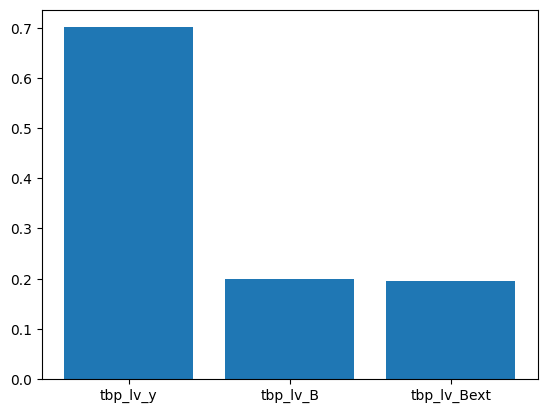

In [21]:
anatom_site_general_corr_matrix = {col: round(anatom_site_general_encoded.corr(df[col]),  4) for col in feature_cols if df[col].dtype == 'float64'}

sorted_corr = dict(sorted(anatom_site_general_corr_matrix.items(), key=lambda item: item[1], reverse=True)[:3])

plt.bar(sorted_corr.keys(), sorted_corr.values())
plt.show()

таким образом, видно, что наиольшим образом анатомическое расположение поражения связано с координатой y снимка очага. заменим пропуски модой по координате y

In [22]:
print("Количество пропусков в 'anatom_site_general':", df['anatom_site_general'].isna().sum())

df['tbp_lv_y_segment'] = pd.qcut(df['tbp_lv_y'], q=len(df['anatom_site_general'].unique()))


for segment in df['tbp_lv_y_segment'].unique():
    mode_value = df[df['tbp_lv_y_segment'] == segment]['anatom_site_general'].mode()
    if not mode_value.empty:
        df.loc[(df['tbp_lv_y_segment'] == segment) & (df['anatom_site_general'].isna()), 'anatom_site_general'] = mode_value[0]

df.drop(['tbp_lv_y_segment'], axis = 1, inplace = True)
print("Количество оставшихся пропусков в 'anatom_site_general':", df['anatom_site_general'].isna().sum())

Количество пропусков в 'anatom_site_general': 5756
Количество оставшихся пропусков в 'anatom_site_general': 0


In [31]:
import gc
gc.collect()

0

## поиск зависимостей

рассмотрим все линейные зависимости с помощью heatmap

In [33]:
df.columns

Index(['isic_id', 'target', 'patient_id', 'age_approx', 'sex',
       'anatom_site_general', 'clin_size_long_diam_mm', 'image_type',
       'tbp_tile_type', 'tbp_lv_A', 'tbp_lv_Aext', 'tbp_lv_B', 'tbp_lv_Bext',
       'tbp_lv_C', 'tbp_lv_Cext', 'tbp_lv_H', 'tbp_lv_Hext', 'tbp_lv_L',
       'tbp_lv_Lext', 'tbp_lv_areaMM2', 'tbp_lv_area_perim_ratio',
       'tbp_lv_color_std_mean', 'tbp_lv_deltaA', 'tbp_lv_deltaB',
       'tbp_lv_deltaL', 'tbp_lv_deltaLB', 'tbp_lv_deltaLBnorm',
       'tbp_lv_eccentricity', 'tbp_lv_location', 'tbp_lv_location_simple',
       'tbp_lv_minorAxisMM', 'tbp_lv_nevi_confidence', 'tbp_lv_norm_border',
       'tbp_lv_norm_color', 'tbp_lv_perimeterMM',
       'tbp_lv_radial_color_std_max', 'tbp_lv_stdL', 'tbp_lv_stdLExt',
       'tbp_lv_symm_2axis', 'tbp_lv_symm_2axis_angle', 'tbp_lv_x', 'tbp_lv_y',
       'tbp_lv_z', 'attribution', 'copyright_license'],
      dtype='object')

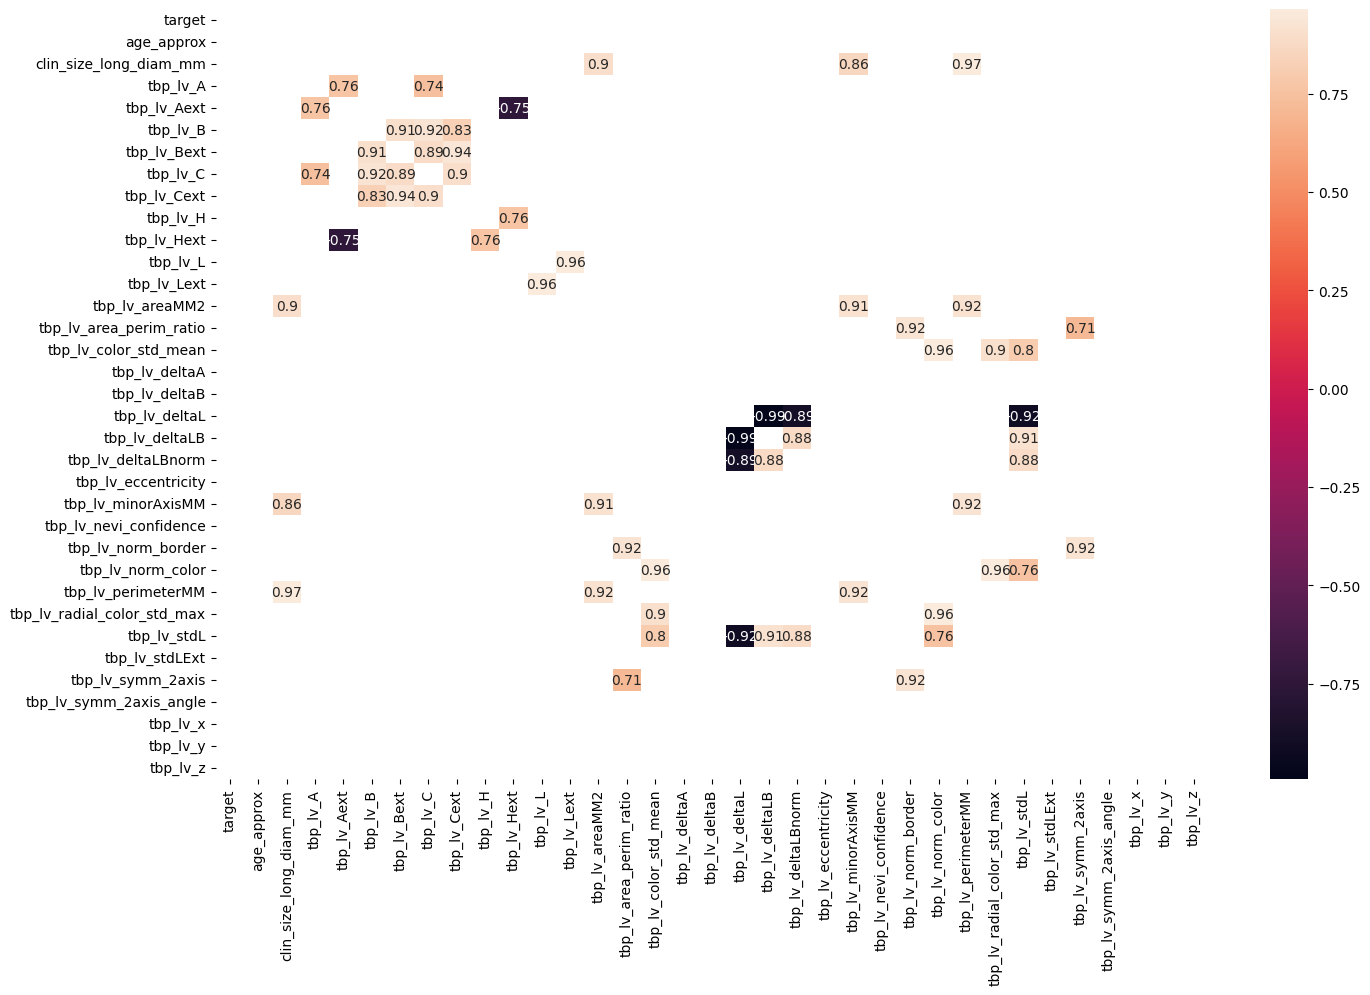

In [42]:
mat_corr = df.drop(list(df.select_dtypes(include='object')), axis = 1).corr()
filtered_correlations = mat_corr[(mat_corr.abs() > 0.7) & (mat_corr != 1.0)] # оставим только самые большие значения

plt.figure(figsize = (16, 10))
sns.heatmap(filtered_correlations, annot=True)
plt.show()

из корреляционной матрицы видно, что довольно большое количество признаков являются сильно линейно зависимыми, что может помочь в будущем уменьшить количество признаков для увеличения скорости обучения.

теперь взглянем на матрицу корреляций нелинейных зависимостей с помощью библиотеки phik

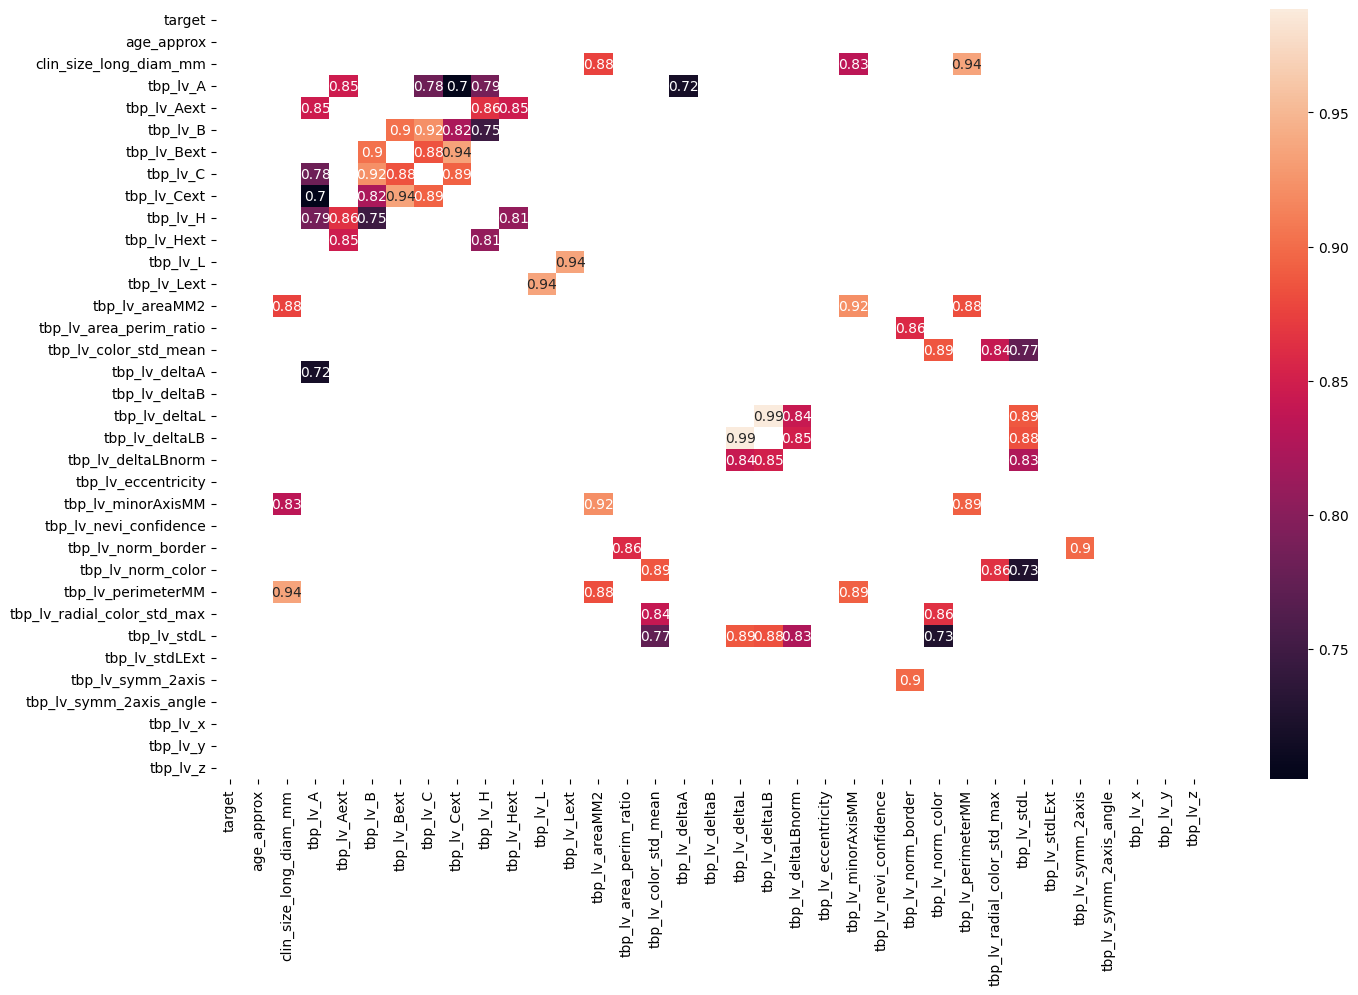

In [45]:
mat_all_corr = df.drop(list(df.select_dtypes(include='object')), axis = 1).phik_matrix(verbose=False)
filtered_all_correlations = mat_all_corr[(mat_all_corr.abs() > 0.7) & (mat_all_corr != 1.0)] # оставим только самые большие значения

plt.figure(figsize = (16, 10))
sns.heatmap(filtered_all_correlations, annot=True)
plt.show()

стоит проверить, есть ли среди этих зависимостей нелинейные. для этого посмотрим, какие признаки коррелировали в обоих случаях и сравним их

In [47]:
features_1 = set(filtered_correlations.columns)
features_2 = set(filtered_all_correlations.columns)

# Проверяем совпадение признаков
if features_1 != features_2:
    print("Признаки не совпадают:")
    print("Признаки в первой матрице:", features_1 - features_2)
    print("Признаки во второй матрице:", features_2 - features_1)
else:
    print("Признаки совпадают в обеих матрицах.")

Признаки совпадают в обеих матрицах.


In [68]:
for feature in filtered_correlations.index:
    if feature in filtered_all_correlations.index:
        for other_feature in filtered_correlations.columns:
            if other_feature in filtered_all_correlations.columns:
                corr_1 = filtered_correlations.loc[feature, other_feature]
                corr_2 = filtered_all_correlations.loc[feature, other_feature]
                if corr_1 != corr_2 and not np.isnan(corr_1):
                    diff = corr_1 - corr_2
                    if abs(diff) > 0.5:
                        print("           НЕЛИНЕЙНАЯ ЗАВИСИМОСТЬ           ")
                    print(f"ПРИЗНАКИ: {feature} и {other_feature} | РАЗНИЦА: {diff}")


ПРИЗНАКИ: clin_size_long_diam_mm и tbp_lv_areaMM2 | РАЗНИЦА: 0.027222930168770976
ПРИЗНАКИ: clin_size_long_diam_mm и tbp_lv_minorAxisMM | РАЗНИЦА: 0.02483618138013355
ПРИЗНАКИ: clin_size_long_diam_mm и tbp_lv_perimeterMM | РАЗНИЦА: 0.028268322943119872
ПРИЗНАКИ: tbp_lv_A и tbp_lv_Aext | РАЗНИЦА: -0.08640280183131865
ПРИЗНАКИ: tbp_lv_A и tbp_lv_C | РАЗНИЦА: -0.045878129905413734
ПРИЗНАКИ: tbp_lv_Aext и tbp_lv_A | РАЗНИЦА: -0.08640280183131865
           НЕЛИНЕЙНАЯ ЗАВИСИМОСТЬ           
ПРИЗНАКИ: tbp_lv_Aext и tbp_lv_Hext | РАЗНИЦА: -1.5960489523302521
ПРИЗНАКИ: tbp_lv_B и tbp_lv_Bext | РАЗНИЦА: 0.0066175731206112864
ПРИЗНАКИ: tbp_lv_B и tbp_lv_C | РАЗНИЦА: -0.001996521427996445
ПРИЗНАКИ: tbp_lv_B и tbp_lv_Cext | РАЗНИЦА: 0.004074362048084312
ПРИЗНАКИ: tbp_lv_Bext и tbp_lv_B | РАЗНИЦА: 0.0066175731206112864
ПРИЗНАКИ: tbp_lv_Bext и tbp_lv_C | РАЗНИЦА: 0.0007595347612999737
ПРИЗНАКИ: tbp_lv_Bext и tbp_lv_Cext | РАЗНИЦА: 0.004928052426646734
ПРИЗНАКИ: tbp_lv_C и tbp_lv_A | РАЗНИЦА: -0.0458

отсюда видно, что в данных есть сразу несколько нелинейных зависимостей между признаками

# отбор признаков
так как многие признаки имеют сильную линейную зависимость, объединим наиболее коллинеарные признаки в один, с остальными справится регуляризация.

In [87]:
threshold = 0.9

norm_cols = num_cols.copy()

corr_matrix_copy = mat_corr.abs().copy()

for i in range(len(corr_matrix_copy.columns)):
    for j in range(i):
        if abs(corr_matrix_copy.iloc[i, j]) > threshold:
            colname1 = corr_matrix_copy.columns[i]
            colname2 = corr_matrix_copy.columns[j]

            if mat_corr.iloc[i, j] > 0:
                combined_feature = df[colname1] + df[colname2]
            else:
                combined_feature = df[colname1] - df[colname2]

            new_col_name = f"{colname1}_combined_with_{colname2}"
            df[new_col_name] = combined_feature
            norm_cols.append(new_col_name)

            if colname1 in norm_cols:
                norm_cols.remove(colname1)
            if colname2 in norm_cols:
                norm_cols.remove(colname2)

df[norm_cols].head()

,age_approx,tbp_lv_A,tbp_lv_Aext,tbp_lv_H,tbp_lv_Hext,tbp_lv_deltaA,tbp_lv_deltaB,tbp_lv_deltaLBnorm,tbp_lv_eccentricity,tbp_lv_nevi_confidence,...,tbp_lv_norm_border_combined_with_tbp_lv_area_perim_ratio,tbp_lv_norm_color_combined_with_tbp_lv_color_std_mean,tbp_lv_perimeterMM_combined_with_clin_size_long_diam_mm,tbp_lv_perimeterMM_combined_with_tbp_lv_areaMM2,tbp_lv_perimeterMM_combined_with_tbp_lv_minorAxisMM,tbp_lv_radial_color_std_max_combined_with_tbp_lv_color_std_mean,tbp_lv_radial_color_std_max_combined_with_tbp_lv_norm_color,tbp_lv_stdL_combined_with_tbp_lv_deltaL,tbp_lv_stdL_combined_with_tbp_lv_deltaLB,tbp_lv_symm_2axis_combined_with_tbp_lv_norm_border
0,60.0,20.244422,16.261975,53.058545,55.828924,3.982447,2.967674,5.784302,0.901302,2.628592e-03,...,34.567529,0.000000,12.347003,12.459565,10.850019,0.00000,0.000000,9.694449,10.396761,7.681836
1,60.0,31.712570,25.364740,39.702910,44.064040,6.347830,1.781713,4.987244,0.639885,1.334303e-07,...,14.351692,0.000000,4.454148,4.273645,4.176066,0.00000,0.000000,7.354065,7.692235,2.402116
2,60.0,22.575830,17.128170,59.265850,62.909730,5.447655,4.485044,6.290359,0.932147,2.959177e-04,...,28.982955,0.000000,12.286309,12.151462,10.081214,0.00000,0.000000,9.452987,10.836027,5.160240
3,65.0,14.242329,12.164757,56.414429,60.060388,2.077572,0.326788,6.400196,0.654458,2.198945e+01,...,16.865116,2.286225,12.734499,15.594439,11.995827,1.17921,2.436394,5.923864,6.041953,2.185455
4,55.0,24.725520,20.057470,46.946070,52.041180,4.668053,0.754434,6.531302,0.946448,1.378832e-03,...,23.561414,0.000000,9.197562,8.569270,7.397478,0.00000,0.000000,10.664840,11.233904,3.972287


переведем категориальные признаки в числовые с помощью label encoder

In [94]:
for col in cat_cols:
  label_encoder = LabelEncoder()
  df[col] = label_encoder.fit_transform(df[col])

df[cat_cols].head()

,sex,anatom_site_general,tbp_tile_type,tbp_lv_location,tbp_lv_location_simple,attribution
0,1,2,1,12,4,4
1,1,1,1,0,0,4
2,1,3,0,16,5,4
3,1,0,0,19,6,0
4,1,0,1,19,6,4


нормализуем нужные признаки для обучения линейных моделей

сохраню обработанный датасет для экономии времени в будущем

In [143]:
# file_name_1 = '/content/drive/MyDrive/Colab Notebooks/ISIC_hack/meta_data_1'
# df.to_csv(file_name_1, sep='\t', encoding='utf-8', index=False, header=True)

# кастомная метрика

In [28]:
def custom_metric(estimator, X, y_true):
    y_hat = estimator.predict_proba(X)[:, 1]
    min_tpr = 0.80
    max_fpr = abs(1 - min_tpr)

    v_gt = abs(y_true - 1)
    v_pred = np.array([1.0 - x for x in y_hat])

    partial_auc_scaled = roc_auc_score(v_gt, v_pred, max_fpr=max_fpr)
    partial_auc = 0.5 * max_fpr**2 + (max_fpr - 0.5 * max_fpr**2) / (1.0 - 0.5) * (partial_auc_scaled - 0.5)

    return partial_auc

In [29]:
def custom_predict(estimator, X):
    y_hat = estimator.predict_proba(X)[:, 1]
    min_tpr = 0.80
    max_fpr = abs(1 - min_tpr)

    v_pred = np.array([1.0 - x for x in y_hat])
    return v_pred

# Лог Регрессия

сравним обучение на ненормированных данных с зависимыми признаками и с обработанными признаками

In [30]:
df = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/ISIC_hack/meta_data_1',  sep='\t')
norm_cols = [col for col in df.columns if 'combined_with' in col]
df.head(3)

,isic_id,target,patient_id,age_approx,sex,anatom_site_general,clin_size_long_diam_mm,image_type,tbp_tile_type,tbp_lv_A,...,tbp_lv_norm_border_combined_with_tbp_lv_area_perim_ratio,tbp_lv_norm_color_combined_with_tbp_lv_color_std_mean,tbp_lv_perimeterMM_combined_with_clin_size_long_diam_mm,tbp_lv_perimeterMM_combined_with_tbp_lv_areaMM2,tbp_lv_perimeterMM_combined_with_tbp_lv_minorAxisMM,tbp_lv_radial_color_std_max_combined_with_tbp_lv_color_std_mean,tbp_lv_radial_color_std_max_combined_with_tbp_lv_norm_color,tbp_lv_stdL_combined_with_tbp_lv_deltaL,tbp_lv_stdL_combined_with_tbp_lv_deltaLB,tbp_lv_symm_2axis_combined_with_tbp_lv_norm_border
0,ISIC_0015670,0,IP_1235828,60.0,1,2,3.04,TBP tile: close-up,1,20.244422,...,34.567529,0.0,12.347003,12.459565,10.850019,0.0,0.0,9.694449,10.396761,7.681836
1,ISIC_0015845,0,IP_8170065,60.0,1,1,1.10,TBP tile: close-up,1,31.712570,...,14.351692,0.0,4.454148,4.273645,4.176066,0.0,0.0,7.354065,7.692235,2.402116
2,ISIC_0015864,0,IP_6724798,60.0,1,3,3.40,TBP tile: close-up,0,22.575830,...,28.982955,0.0,12.286309,12.151462,10.081214,0.0,0.0,9.452987,10.836027,5.160240


In [31]:
X = df[list(set(num_cols + norm_cols)) + cat_cols]
y = df['target']
groups = df['patient_id']
cv = StratifiedGroupKFold(10, shuffle=True)

In [32]:
log_reg_1 = Pipeline([
    ('scaler', StandardScaler()),
    ('sampler_1', RandomOverSampler(sampling_strategy= 0.003 , random_state=2345)),
    ('sampler_2', RandomUnderSampler(sampling_strategy=0.01, random_state=1345)),
    ('classifier', LogisticRegression(n_jobs=-1, class_weight="balanced"))
])
log_reg_2 = Pipeline([
    ('sampler_1', RandomOverSampler(sampling_strategy= 0.003 , random_state=2345)),
    ('sampler_2', RandomUnderSampler(sampling_strategy=0.01, random_state=1345)),
    ('classifier', LogisticRegression(n_jobs=-1, class_weight="balanced"))
])

for model, x in ((log_reg_1, X), (log_reg_2, X[num_cols + cat_cols])):
    cross_val = cross_validate(
        estimator=model,
        X=x, y=y,
        cv=cv,
        groups=groups,
        scoring={'recall': make_scorer(recall_score), 'custom_metric': custom_metric},
    )

    print(f'recall: {np.mean(cross_val["test_recall"])} custom_metric: {np.mean(cross_val["test_custom_metric"])}')

recall: 0.7702623913058696 custom_metric: 0.12804243693073908
recall: 0.7524953444232729 custom_metric: 0.1198743579772443


отсюда видно, что предобработанные данные c использованием скрещенных признаков справляются на пару процентов лучше

In [33]:
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=42, test_size=0.4, stratify=y)

In [34]:
log_reg_pipe = Pipeline([
    ('scaler', StandardScaler()),
    ('sampler_1', RandomOverSampler(sampling_strategy= 0.003 , random_state=2345)),
    ('sampler_2', RandomUnderSampler(sampling_strategy=0.01, random_state=1345)),
    ('classifier', LogisticRegression(n_jobs=-1, class_weight="balanced"))
]).fit(X_train, y_train)

In [36]:
y_pred = log_reg_pipe.predict(X_test)
print(f'recall: {recall_score(y_test, y_pred)} custom_metric: {custom_metric(log_reg_pipe, X_test, y_test)}')

recall: 0.7643312101910829 custom_metric: 0.1311468731776777


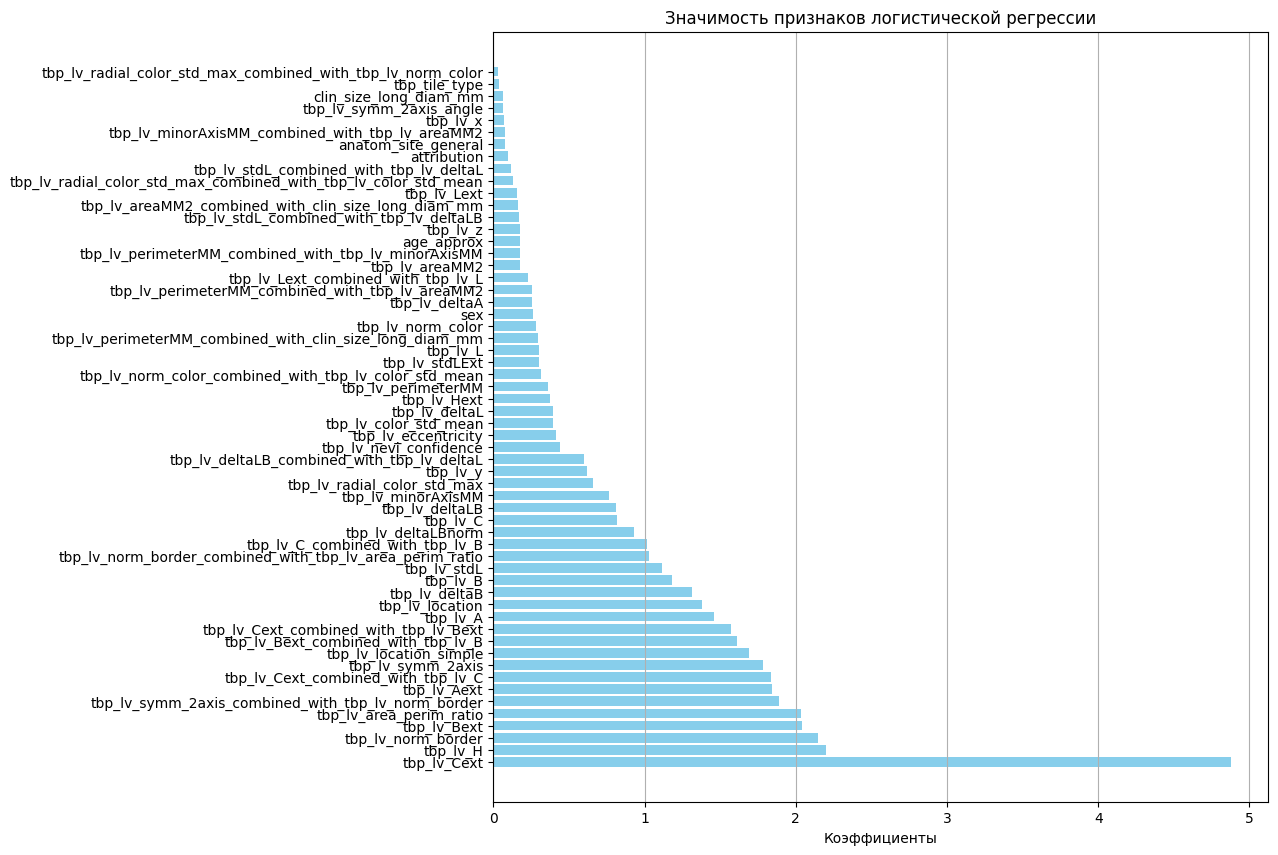

In [44]:
importance = abs(log_reg_pipe[-1].coef_[0])

coef_df = pd.DataFrame({'Feature': X.columns, 'Importance': importance})
coef_df = coef_df.sort_values(by='Importance', ascending=False)

# визуализация значимости признаков
plt.figure(figsize=(10, 10))
plt.barh(coef_df['Feature'], coef_df['Importance'], color='skyblue')
plt.xlabel('Коэффициенты')
plt.title('Значимость признаков логистической регрессии')
plt.grid(axis='x')
plt.show()

из графика видно, что наиболее значимыми признаками являются объединенные ранее коллинеарные признаки, следовательно, предварительный анализ признаков действительно дал результат

In [48]:
imp_logreg_cols = coef_df[coef_df['Importance'] >= 0.5]['Feature'].to_list()

In [49]:
log_reg_pipe_2 = Pipeline([
    ('scaler', StandardScaler()),
    ('sampler_1', RandomOverSampler(sampling_strategy= 0.003 , random_state=2345)),
    ('sampler_2', RandomUnderSampler(sampling_strategy=0.01, random_state=1345)),
    ('classifier', LogisticRegression(n_jobs=-1, class_weight="balanced"))
]).fit(X_train[imp_logreg_cols], y_train)

In [50]:
y_pred = log_reg_pipe_2.predict(X_test[imp_logreg_cols])
print(f'recall: {recall_score(y_test, y_pred)} custom_metric: {custom_metric(log_reg_pipe_2, X_test[imp_logreg_cols], y_test)}')

recall: 0.7643312101910829 custom_metric: 0.1142891605366029


# создание новых признаков
для начала импортируем предобработанный датасет

In [5]:
df = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/ISIC_hack/meta_data_1', sep = '\t')
norm_cols = [col for col in df.columns if 'combined_with' in col]
df.head()

,isic_id,target,patient_id,age_approx,sex,anatom_site_general,clin_size_long_diam_mm,image_type,tbp_tile_type,tbp_lv_A,...,tbp_lv_norm_border_combined_with_tbp_lv_area_perim_ratio,tbp_lv_norm_color_combined_with_tbp_lv_color_std_mean,tbp_lv_perimeterMM_combined_with_clin_size_long_diam_mm,tbp_lv_perimeterMM_combined_with_tbp_lv_areaMM2,tbp_lv_perimeterMM_combined_with_tbp_lv_minorAxisMM,tbp_lv_radial_color_std_max_combined_with_tbp_lv_color_std_mean,tbp_lv_radial_color_std_max_combined_with_tbp_lv_norm_color,tbp_lv_stdL_combined_with_tbp_lv_deltaL,tbp_lv_stdL_combined_with_tbp_lv_deltaLB,tbp_lv_symm_2axis_combined_with_tbp_lv_norm_border
0,ISIC_0015670,0,IP_1235828,60.0,1,2,3.04,TBP tile: close-up,1,20.244422,...,34.567529,0.000000,12.347003,12.459565,10.850019,0.00000,0.000000,9.694449,10.396761,7.681836
1,ISIC_0015845,0,IP_8170065,60.0,1,1,1.10,TBP tile: close-up,1,31.712570,...,14.351692,0.000000,4.454148,4.273645,4.176066,0.00000,0.000000,7.354065,7.692235,2.402116
2,ISIC_0015864,0,IP_6724798,60.0,1,3,3.40,TBP tile: close-up,0,22.575830,...,28.982955,0.000000,12.286309,12.151462,10.081214,0.00000,0.000000,9.452987,10.836027,5.160240
3,ISIC_0015902,0,IP_4111386,65.0,1,0,3.22,TBP tile: close-up,0,14.242329,...,16.865116,2.286225,12.734499,15.594439,11.995827,1.17921,2.436394,5.923864,6.041953,2.185455
4,ISIC_0024200,0,IP_8313778,55.0,1,0,2.73,TBP tile: close-up,1,24.725520,...,23.561414,0.000000,9.197562,8.569270,7.397478,0.00000,0.000000,10.664840,11.233904,3.972287


очевидно, что четко разделимых графических зависимостей найти не получится, так как классы слишком несбалансированные, поэтому добавим новые арифметические непрерывные признаки, основываясь на знаниях предметной области

In [51]:
new_num_cols = [
'lesion_size_ratio',# tbp_lv_minorAxisMM / clin_size_long_diam_mm
'lesion_shape_index', # tbp_lv_areaMM2/ tbp_lv_perimeterMM **2
'hue_contrast',# tbp_lv_H - tbp_lv_Hextabs
'luminance_contrast', # tbp_lv_L - tbp_lv_Lextabs
'lesion_color_difference', # tbp_lv_deltaA **2+ tbp_lv_deltaB **2 + tbp_lv_deltaL **2sqrt
'border_complexity',# tbp_lv_norm_border + tbp_lv_symm_2axis
'color_uniformity', # tbp_lv_color_std_mean / tbp_lv_radial_color_std_max
'position_distance_3d',# tbp_lv_x **2 + tbp_lv_y **2 + tbp_lv_z **2sqrt
'perimeter_to_area_ratio', # tbp_lv_perimeterMM / tbp_lv_areaMM2
'area_to_perimeter_ratio', # tbp_lv_areaMM2/ tbp_lv_perimeterMM
'lesion_visibility_score', # tbp_lv_deltaLBnorm + tbp_lv_norm_color
'symmetry_border_consistency',# tbp_lv_symm_2axis* tbp_lv_norm_border
'consistency_symmetry_border',# tbp_lv_symm_2axis* tbp_lv_norm_border / (tbp_lv_symm_2axis + tbp_lv_norm_border)
'color_consistency',# tbp_lv_stdL / tbp_lv_Lext
'consistency_color',# tbp_lv_stdL*tbp_lv_Lext / tbp_lv_stdL + tbp_lv_Lext
'size_age_interaction',# clin_size_long_diam_mm* age_approx
'hue_color_std_interaction',# tbp_lv_H * tbp_lv_color_std_mean
'lesion_severity_index', # tbp_lv_norm_border + tbp_lv_norm_color + tbp_lv_eccentricity / 3
'shape_complexity_index',# border_complexity+ lesion_shape_index
'color_contrast_index',# tbp_lv_deltaA + tbp_lv_deltaB + tbp_lv_deltaL + tbp_lv_deltaLBnorm
'log_lesion_area',# tbp_lv_areaMM2+ 1np.log
'normalized_lesion_size',# clin_size_long_diam_mm/ age_approx
'mean_hue_difference',# tbp_lv_H + tbp_lv_Hext/ 2
'std_dev_contrast', # tbp_lv_deltaA **2 + tbp_lv_deltaB **2 + tbp_lv_deltaL **2 / 3np.sqrt
'color_shape_composite_index',# tbp_lv_color_std_mean + bp_lv_area_perim_ratio + tbp_lv_symm_2axis / 3
'lesion_orientation_3d', # tbp_lv_y , tbp_lv_xnp.arctan2
'overall_color_difference',# tbp_lv_deltaA + tbp_lv_deltaB + tbp_lv_deltaL / 3
'symmetry_perimeter_interaction',# tbp_lv_symm_2axis* tbp_lv_perimeterMM
'comprehensive_lesion_index', # tbp_lv_area_perim_ratio + tbp_lv_eccentricity + bp_lv_norm_color + tbp_lv_symm_2axis / 4
'color_variance_ratio',# tbp_lv_color_std_mean / tbp_lv_stdLExt
'border_color_interaction',# tbp_lv_norm_border * tbp_lv_norm_color
'border_color_interaction_2',
'size_color_contrast_ratio',# clin_size_long_diam_mm/ tbp_lv_deltaLBnorm
'age_normalized_nevi_confidence',# tbp_lv_nevi_confidence/ age_approx
'age_normalized_nevi_confidence_2',
'color_asymmetry_index', # tbp_lv_symm_2axis* tbp_lv_radial_color_std_max
'volume_approximation_3d', # tbp_lv_areaMM2 * sqrt(tbp_lv_x**2 + tbp_lv_y**2 + tbp_lv_z**2)
'color_range', # abs(tbp_lv_L - tbp_lv_Lext) + abs(tbp_lv_A - tbp_lv_Aext) + abs(tbp_lv_B - tbp_lv_Bext)
'shape_color_consistency', # tbp_lv_eccentricity * tbp_lv_color_std_mean
'border_length_ratio',# tbp_lv_perimeterMM / pi * sqrt(tbp_lv_areaMM2 / pi)
'age_size_symmetry_index', # age_approx * clin_size_long_diam_mm * tbp_lv_symm_2axis
'index_age_size_symmetry', # age_approx * tbp_lv_areaMM2 * tbp_lv_symm_2axis
'isic_count'
]

In [160]:
def add_new_features(df):
    # Признаки, которые необходимо добавить, и их формулы
    new_num_cols = {
        'lesion_size_ratio': lambda df: df['tbp_lv_minorAxisMM'] / df['clin_size_long_diam_mm'],
        'lesion_shape_index': lambda df: df['tbp_lv_areaMM2'] / (df['tbp_lv_perimeterMM'] ** 2),
        'hue_contrast': lambda df: np.abs(df['tbp_lv_H'] - df['tbp_lv_Hext']),
        'luminance_contrast': lambda df: np.abs(df['tbp_lv_L'] - df['tbp_lv_Lext']),
        'lesion_color_difference': lambda df: np.sqrt(df['tbp_lv_deltaA'] ** 2 +
                                                       df['tbp_lv_deltaB'] ** 2 +
                                                       df['tbp_lv_deltaL'] ** 2),
        'border_complexity': lambda df: df['tbp_lv_norm_border'] + df['tbp_lv_symm_2axis'],
        'color_uniformity': lambda df: df['tbp_lv_color_std_mean'] / (df['tbp_lv_radial_color_std_max'] + 1e-7),
        'position_distance_3d': lambda df: np.sqrt(df['tbp_lv_x'] ** 2 +
                                                    df['tbp_lv_y'] ** 2 +
                                                    df['tbp_lv_z'] ** 2),
        'perimeter_to_area_ratio': lambda df: df['tbp_lv_perimeterMM'] / df['tbp_lv_areaMM2'],
        'area_to_perimeter_ratio': lambda df: df['tbp_lv_areaMM2'] / df['tbp_lv_perimeterMM'],
        'lesion_visibility_score': lambda df: df['tbp_lv_deltaLBnorm'] + df['tbp_lv_norm_color'],
        'symmetry_border_consistency': lambda df: df['tbp_lv_symm_2axis'] * df['tbp_lv_norm_border'],
        'consistency_symmetry_border': lambda df: (df['tbp_lv_symm_2axis'] * df['tbp_lv_norm_border']) / \
                                                  (df['tbp_lv_symm_2axis'] + df['tbp_lv_norm_border']),
        'color_consistency': lambda df: df['tbp_lv_stdL'] / df['tbp_lv_Lext'],
        'consistency_color': lambda df: (df['tbp_lv_stdL'] * df['tbp_lv_Lext']) / \
                                          (df['tbp_lv_stdL'] + df['tbp_lv_Lext']),
        'size_age_interaction': lambda df: df['clin_size_long_diam_mm'] * df['age_approx'],
        'hue_color_std_interaction': lambda df: df['tbp_lv_H'] * df['tbp_lv_color_std_mean'],
        'lesion_severity_index': lambda df: (df['tbp_lv_norm_border'] +
                                              df['tbp_lv_norm_color'] +
                                              df['tbp_lv_eccentricity']) / 3,
        'shape_complexity_index': lambda df: df['border_complexity'] + df['lesion_shape_index'],
        'color_contrast_index': lambda df: (df['tbp_lv_deltaA'] +
                                             df['tbp_lv_deltaB'] +
                                             df['tbp_lv_deltaL'] +
                                             df['tbp_lv_deltaLBnorm']),
        'log_lesion_area': lambda df: np.log(df['tbp_lv_areaMM2'] + 1),
        'normalized_lesion_size': lambda df: df['clin_size_long_diam_mm'] / df['age_approx'],
        'mean_hue_difference': lambda df: (df['tbp_lv_H'] + df['tbp_lv_Hext']) / 2,
        'std_dev_contrast': lambda df: np.sqrt((df['tbp_lv_deltaA'] ** 2 +
                                                  df['tbp_lv_deltaB'] ** 2 +
                                                  df['tbp_lv_deltaL'] ** 2) / 3),
        'color_shape_composite_index': lambda df: (df['tbp_lv_color_std_mean'] +
                                                    df['tbp_lv_area_perim_ratio'] +
                                                    df['tbp_lv_symm_2axis']) / 3,
        'lesion_orientation_3d': lambda df: np.arctan2(df['tbp_lv_y'], df['tbp_lv_x']),
        'overall_color_difference': lambda df: (df['tbp_lv_deltaA'] +
                                                  df['tbp_lv_deltaB'] +
                                                  df['tbp_lv_deltaL']) / 3,
        'symmetry_perimeter_interaction': lambda df: df['tbp_lv_symm_2axis'] * df['tbp_lv_perimeterMM'],
        'comprehensive_lesion_index': lambda df: (df['tbp_lv_area_perim_ratio'] +
                                                   df['tbp_lv_eccentricity'] +
                                                   df['tbp_lv_norm_color'] +
                                                   df['tbp_lv_symm_2axis']) / 4,
        'color_variance_ratio': lambda df: df['tbp_lv_color_std_mean'] / df['tbp_lv_stdLExt'],
        'border_color_interaction': lambda df: df['tbp_lv_norm_border'] * df['tbp_lv_norm_color'],
        'size_color_contrast_ratio': lambda df: df['clin_size_long_diam_mm'] / df['tbp_lv_deltaLBnorm'],
        'age_normalized_nevi_confidence': lambda df: df['tbp_lv_nevi_confidence'] / df['age_approx'],
        'color_asymmetry_index': lambda df: df['tbp_lv_symm_2axis'] * df['tbp_lv_radial_color_std_max'],
        'volume_approximation_3d': lambda df: df['tbp_lv_areaMM2'] * np.sqrt(df['tbp_lv_x'] ** 2 +
                                                                                    df['tbp_lv_y'] ** 2 +
                                                                                    df['tbp_lv_z'] ** 2),
        'color_range': lambda df: (np.abs(df['tbp_lv_L'] - df['tbp_lv_Lext']) +
                                    np.abs(df['tbp_lv_A'] - df['tbp_lv_Aext']) +
                                    np.abs(df['tbp_lv_B'] - df['tbp_lv_Bext'])),
        'shape_color_consistency': lambda df: df['tbp_lv_eccentricity'] * df['tbp_lv_color_std_mean'],
        'border_length_ratio': lambda df: df['tbp_lv_perimeterMM'] / (np.pi * np.sqrt(df['tbp_lv_areaMM2'] / np.pi)),
        'age_size_symmetry_index': lambda df: df['age_approx'] * df['clin_size_long_diam_mm'] * df['tbp_lv_symm_2axis'],
        'index_age_size_symmetry': lambda df: df['age_approx'] * df['tbp_lv_areaMM2'] * df['tbp_lv_symm_2axis'],
        'border_color_interaction_2': lambda df: df['tbp_lv_norm_border'] * df['tbp_lv_norm_color'] /
         (df['tbp_lv_norm_border'] + df['tbp_lv_norm_color']),
        'age_normalized_nevi_confidence_2': lambda df: (df['clin_size_long_diam_mm']**2 + df['age_approx']**2).pow(1./2)
    }

    for new_col, formula in new_num_cols.items():
        df[new_col] = formula(df)

    return df

In [161]:
add_new_features(df)[new_num_cols].info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 401059 entries, 0 to 401058
Data columns (total 43 columns):
 #   Column                            Non-Null Count   Dtype  
---  ------                            --------------   -----  
 0   lesion_size_ratio                 401059 non-null  float64
 1   lesion_shape_index                401059 non-null  float64
 2   hue_contrast                      401059 non-null  float64
 3   luminance_contrast                401059 non-null  float64
 4   lesion_color_difference           401059 non-null  float64
 5   border_complexity                 401059 non-null  float64
 6   color_uniformity                  401059 non-null  float64
 7   position_distance_3d              401059 non-null  float64
 8   perimeter_to_area_ratio           401059 non-null  float64
 9   area_to_perimeter_ratio           401059 non-null  float64
 10  lesion_visibility_score           401059 non-null  float64
 11  symmetry_border_consistency       401059 non-null  f

добавим колонку, в которой будет подсчет снимков, сделанных с участием данного пациента

In [100]:
isic_count = df.groupby('patient_id')['isic_id'].agg('count').reset_index().rename(columns={'isic_id': 'isic_count'})
isic_count.head()

,patient_id,isic_count
0,IP_0008821,102
1,IP_0014998,352
2,IP_0023586,939
3,IP_0028775,212
4,IP_0028993,225


In [101]:
df = pd.merge(left=df, right=isic_count, on='patient_id', how='inner')
df.isic_count.value_counts()

,count
isic_count,
9184,9184
6267,6267
5568,5568
4454,4454
3583,3583
...,...
14,14
13,13
3,6


классов слишком много, поэтому пока отнесем данный признак к непрерывным. в будущем разобьем его на интервалы и превратим в категориальный.

In [53]:
import gc
# del isic_count

new_num_cols.append('isic_count')
gc.collect()

23472

In [123]:
df[new_num_cols] = df[new_num_cols].astype('float32')

In [225]:
df.to_csv('/content/drive/MyDrive/Colab Notebooks/ISIC_hack/train_metadata_2', encoding='utf-8', index=False, header=True)

# Лог Регрессия 2

проверим, насколько улучшатся показатели с новымии признаками на базовой модели лог регрессии

In [55]:
df = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/ISIC_hack/train_metadata_2')

In [56]:
X = df[list(set(num_cols + norm_cols)) + cat_cols + new_num_cols]
y = df['target']
groups = df['patient_id']
cv = StratifiedGroupKFold(10, shuffle=True)

In [58]:
log_reg_3 = Pipeline([
    ('scaler', StandardScaler()),
    ('sampler_1', RandomOverSampler(sampling_strategy= 0.003 , random_state=2345)),
    ('sampler_2', RandomUnderSampler(sampling_strategy=0.01, random_state=1345)),
    ('classifier', LogisticRegression(n_jobs=-1, class_weight="balanced"))
])
log_reg_4 = Pipeline([
    ('scaler', StandardScaler()),
    ('sampler_1', RandomOverSampler(sampling_strategy= 0.003 , random_state=2345)),
    ('sampler_2', RandomUnderSampler(sampling_strategy=0.01, random_state=1345)),
    ('classifier', LogisticRegression(n_jobs=-1, class_weight="balanced"))
])

for model, x in ((log_reg_3, X), (log_reg_4, X[list(set(feature_cols + norm_cols))])):
    cross_val = cross_validate(
        estimator=model,
        X=x, y=y,
        cv=cv,
        groups=groups,
        scoring={'recall': make_scorer(recall_score), 'custom_metric': custom_metric},
    )

    print(f'recall: {np.mean(cross_val["test_recall"])} custom_metric: {np.mean(cross_val["test_custom_metric"])}')

recall: 0.8240368947789175 custom_metric: 0.1457786299599125
recall: 0.7693190327433693 custom_metric: 0.12861464028143574


довольно сильно выросла как кастомная метрика, так и рекол. неплохой результат.

In [63]:
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=42, test_size=0.4, stratify=y)

In [64]:
log_reg_4.fit(X_train, y_train)

Pipeline(steps=[('scaler', StandardScaler()),
                ('sampler_1',
                 RandomOverSampler(random_state=2345, sampling_strategy=0.003)),
                ('sampler_2',
                 RandomUnderSampler(random_state=1345, sampling_strategy=0.01)),
                ('classifier',
                 LogisticRegression(class_weight='balanced', n_jobs=-1))])

In [67]:
y_pred = log_reg_4.predict(X_test)
print(f'recall: {recall_score(y_test, y_pred)} custom_metric: {custom_metric(log_reg_4, X_test, y_test)}')

recall: 0.8471337579617835 custom_metric: 0.1456251011697478


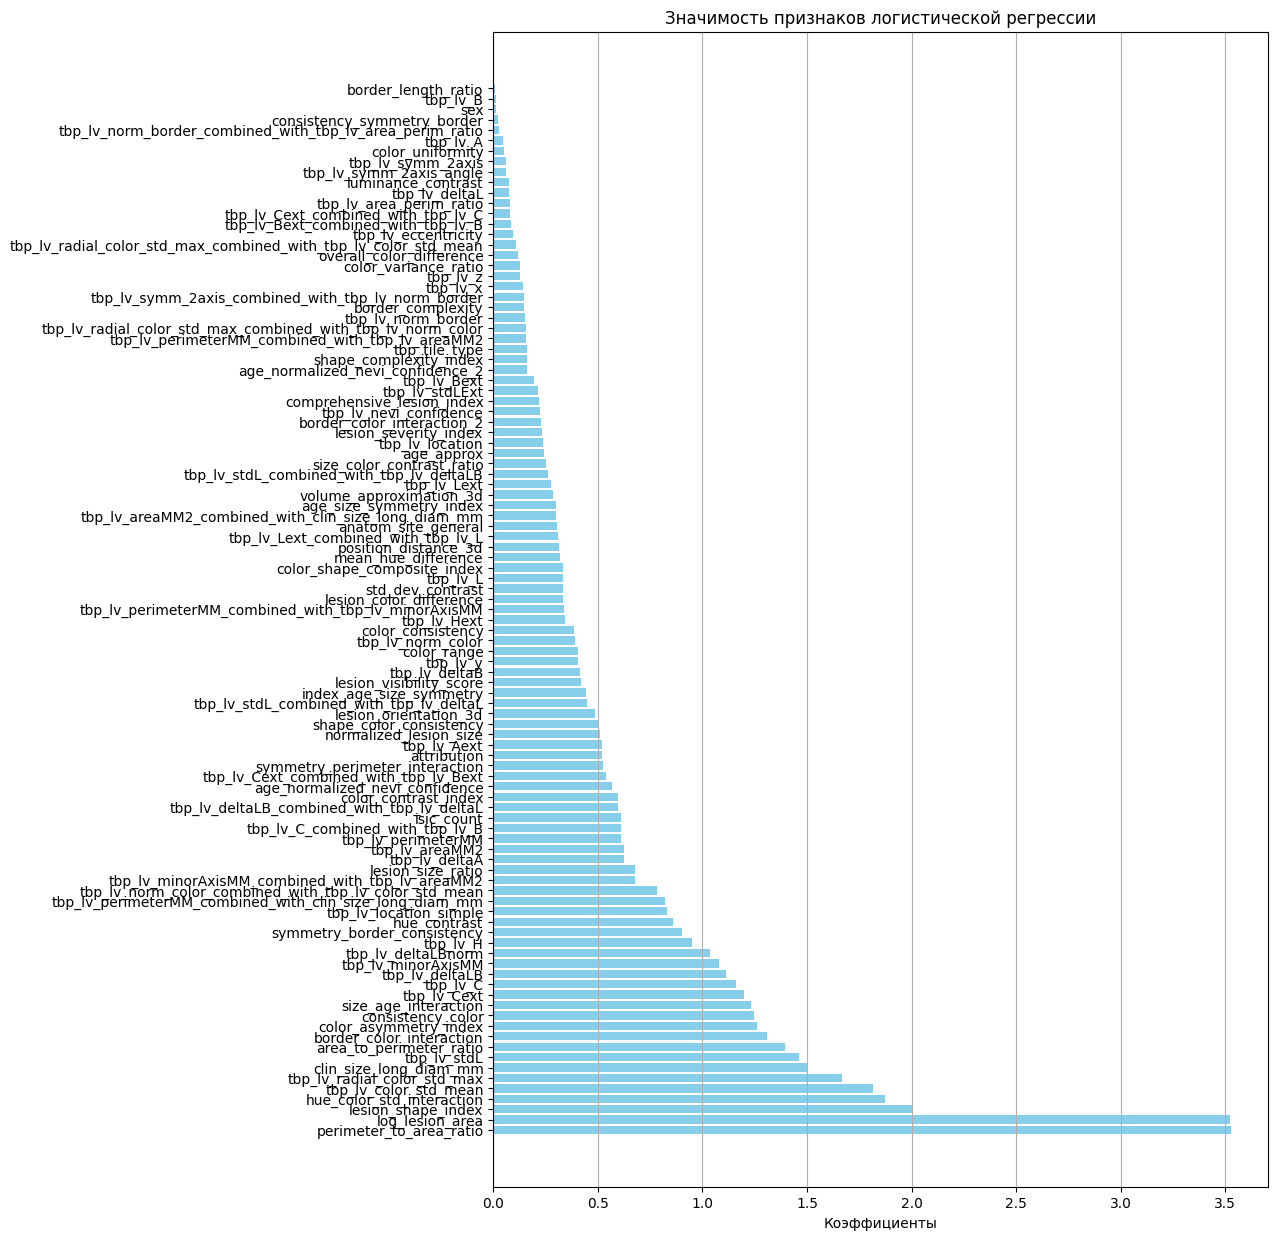

In [69]:
importance = abs(log_reg_4[-1].coef_[0])

coef_df = pd.DataFrame({'Feature': X.columns, 'Importance': importance})
coef_df = coef_df.sort_values(by='Importance', ascending=False)

# визуализация значимости признаков
plt.figure(figsize=(10, 15))
plt.barh(coef_df['Feature'], coef_df['Importance'], color='skyblue')
plt.xlabel('Коэффициенты')
plt.title('Значимость признаков логистической регрессии')
plt.grid(axis='x')
plt.show()

как видим, довольно большое количество новых признаков действительно имеют огропное влияние на обучение модели

# Случайный лес

In [82]:
for max_depth in (1, 4, 8):
  for n_estimators in [100, 200, 300]:
    rf = Pipeline([
      ('sampler_1', RandomOverSampler(sampling_strategy= 0.003 , random_state=2345)),
      ('sampler_2', RandomUnderSampler(sampling_strategy=0.01, random_state=1345)),
      ('classifier', RandomForestClassifier(n_jobs=-1, class_weight="balanced", max_depth=max_depth, n_estimators=n_estimators))
  ]).fit(X_train, y_train)
    print(max_depth, n_estimators)
    print(f'recall: {recall_score(y_test, rf.predict(X_test))} custom_metric: {custom_metric(rf, X_test, y_test)}')

1 100
recall: 0.47770700636942676 custom_metric: 0.07455069066870454
1 200
recall: 0.47770700636942676 custom_metric: 0.07989133897140355
1 300
recall: 0.4713375796178344 custom_metric: 0.07993992827017682
4 100
recall: 0.7579617834394905 custom_metric: 0.13226087406131457
4 200
recall: 0.732484076433121 custom_metric: 0.13457081314028546
4 300
recall: 0.7515923566878981 custom_metric: 0.13402256004400936
8 100
recall: 0.5414012738853503 custom_metric: 0.1441761973719095
8 200
recall: 0.5414012738853503 custom_metric: 0.14305127522268862
8 300
recall: 0.49044585987261147 custom_metric: 0.13915855940876365


In [85]:
rf = Pipeline([
    ('sampler_1', RandomOverSampler(sampling_strategy= 0.003 , random_state=2345)),
    ('sampler_2', RandomUnderSampler(sampling_strategy=0.01, random_state=1345)),
    ('classifier', RandomForestClassifier(n_jobs=-1, class_weight="balanced", max_depth = 4, n_estimators = 100))
])

rf_cross_val = cross_validate(
    estimator=rf,
    X=x, y=y,
    cv=cv,
    groups=groups,
    scoring={'recall': make_scorer(recall_score), 'custom_metric': custom_metric},
)

print(f'recall: {np.mean(rf_cross_val["test_recall"])} custom_metric: {np.mean(rf_cross_val["test_custom_metric"])}')

recall: 0.7546709242364837 custom_metric: 0.14274455808915792
